In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path

path = Path('data')
train_labels = pd.read_csv(path / 'train_labels_tokenized.csv')
train_labels

,image_id,InChI,InChI_1,InChI_text
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...
...,...,...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...,C10H12F2N2O3,C 10 H 12 F 2 N 2 O 3 /c 1 - 17 - 7 - 2 - 5 ( ...
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...,C19H20F2N4O3S,C 19 H 20 F 2 N 4 O 3 S /c 1 - 10 ( 8 - 20 ) 2...
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...,C22H26Cl2N2O4S,C 22 H 26 Cl 2 N 2 O 4 S /c 1 - 16 - 6 - 2 - 3...
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...,C17H26N2O6S,C 17 H 26 N 2 O 6 S /c 1 - 23 - 16 - 12 - 14 (...


In [3]:
from src.utils import parse_config_file

config_file = 'debug.yml'
config = parse_config_file(config_file)
config

{'lr': 0.0003,
 'optimizer': 'Adam',
 'batch_size': 1,
 'gradient_clip_val': 1.0,
 'num_workers': 0,
 'pin_memory': True,
 'subset': 0.001,
 'img_size': 128,
 'patch_size': 16,
 'embed_dim': 256,
 'nhead': 4,
 'num_encoder_layers': 12,
 'num_decoder_layers': 12,
 'dropout': 0.0,
 'max_len': 277,
 'load_from': False,
 'train_trans': {'Resize': {'width': 128, 'height': 128}},
 'val_trans': {'Resize': {'width': 128, 'height': 128}},
 'gpus': 1,
 'precision': 16,
 'max_epochs': 1,
 'train_batches': 1,
 'shuffle_train': False,
 'val_batches': 1,
 'val_with_train': True,
 'log': False}

In [4]:
from src.dm import DataModule

dm = DataModule(**config)
dm.setup()

Training samples:  2181
Validation samples:  243


In [5]:
images, inchis = next(iter(dm.train_dataloader()))
images.shape, inchis.shape

(torch.Size([1, 1, 128, 128]), torch.Size([1, 74]))

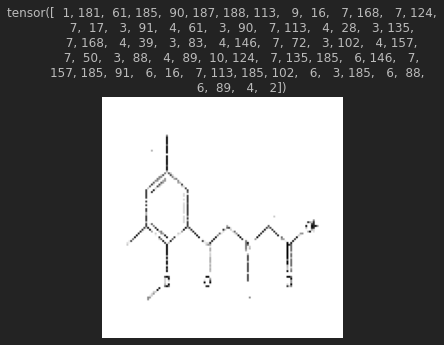

In [6]:
import matplotlib.pyplot as plt
from skimage import io
import random

rows, columns = 1, 1
fig = plt.figure(figsize=(5,5))
ix = 0
for r in range(rows):
    for c in range(columns):
        image = images[ix]
        ax = plt.subplot(rows, columns, ix + 1)
        ax.imshow(image.squeeze(0), cmap="gray")
        ax.axis('off')
        ax.set_title(inchis[ix], size=12)
        ix += 1
plt.tight_layout()
plt.show()

In [7]:
dm.decode(inchis[0].numpy())

'C14H19NO4/c1-9-5-10(2)14(19-4)11(6-9)12(16)7-15(3)8-13(17)18/h5-6H,7-8H2,1-4H3,(H,17,18)'

# Fit one sample

In [19]:
import pytorch_lightning as pl
from src.models import Transformer

config_file = 'debug.yml'
config = parse_config_file(config_file)
config['batch_size'] = 1

dm = DataModule(**config)
model = Transformer(config)

trainer = pl.Trainer(
    gpus=config['gpus'],
    precision=config['precision'],
    max_epochs=20,
    limit_train_batches=config['train_batches'],
    limit_val_batches=config['val_batches']
)

trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name        | Type           | Params
-----------------------------------------------
0 | patch_embed | PatchEmbedding | 65 K  
1 | trg_emb     | Embedding      | 49 K  
2 | trg_pos_emb | Embedding      | 70 K  
3 | transformer | Transformer    | 22 M  
4 | l           | LayerNorm      | 512   
5 | fc          | Linear         | 49 K  


Training samples:  2181
Validation samples:  243


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [25]:
preds = model.predict(images)
preds

tensor([[181,  61, 185,  90, 187, 188, 113,   9,  16,   7, 168,   7, 124,   7,
          17,   3,  91,   4,  61,   3,  90,   7, 113,   4,  28,   3, 135,   7,
         168,   4,  39,   3,  83,   4, 146,   7,  72,   3, 102,   4, 157,   7,
          50,   3,  88,   4,  89,  10, 124,   7, 135, 185,   6, 146,   7, 157,
         185,  91,   6,  16,   7, 113, 185, 102,   6,   3, 185,   6,  88,   6,
          89,   4,   2]])

In [26]:
preds_decoded = [dm.decode(pred) for pred in preds.numpy()]
preds_decoded

['C14H19NO4/c1-9-5-10(2)14(19-4)11(6-9)12(16)7-15(3)8-13(17)18/h5-6H,7-8H2,1-4H3,(H,17,18)']

In [27]:
gt = dm.decode(inchis[0].numpy())
gt

'C14H19NO4/c1-9-5-10(2)14(19-4)11(6-9)12(16)7-15(3)8-13(17)18/h5-6H,7-8H2,1-4H3,(H,17,18)'

In [28]:
from Levenshtein import distance

distance(preds_decoded[0], gt)

0

# Fit one batch

In [29]:
config['batch_size'] = 2

dm = DataModule(**config)
model = Transformer(config)

trainer = pl.Trainer(
    gpus=config['gpus'],
    precision=config['precision'],
    max_epochs=50,
    limit_train_batches=config['train_batches'],
    limit_val_batches=config['val_batches']
)

trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name        | Type           | Params
-----------------------------------------------
0 | patch_embed | PatchEmbedding | 65 K  
1 | trg_emb     | Embedding      | 49 K  
2 | trg_pos_emb | Embedding      | 70 K  
3 | transformer | Transformer    | 22 M  
4 | l           | LayerNorm      | 512   
5 | fc          | Linear         | 49 K  


Training samples:  2181
Validation samples:  243


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [33]:
images, inchis = next(iter(dm.train_dataloader()))
images.shape, inchis.shape

(torch.Size([2, 1, 128, 128]), torch.Size([2, 102]))

In [47]:
preds = model.predict(images)
preds

tensor([[181,  61, 185,  90, 187, 188, 113,   9,  16,   7, 168,   7, 124,   7,
          17,   3,  91,   4,  61,   3,  90,   7, 113,   4,  28,   3, 135,   7,
         168,   4,  39,   3,  83,   4, 146,   7,  72,   3, 102,   4, 157,   7,
          50,   3,  88,   4,  89,  10, 124,   7, 135, 185,   6, 146,   7, 157,
         185,  91,   6,  16,   7, 113, 185, 102,   6,   3, 185,   6,  88,   6,
          89,   4,   2],
        [181,  61, 185,  90, 187, 188, 113,   9,  16,   7, 168,   7, 124,   7,
          17,   3,  91,   4,  61,   3,  90,   7, 113,   4,  28,   3, 135,   7,
         168,   4,  39,   3,  83,   4, 146,   7,  72,   3, 102,   4, 157,   7,
          50,   3,  88,   4,  89,  10, 124,   7, 135, 185,   6, 146,   7, 157,
         185,  91,   6,  16,   7, 113, 185, 102,   6,   3, 185,   6,  88,   6,
          89,   4,   2]])

In [48]:
preds_decoded = [dm.decode(pred) for pred in preds]
preds_decoded

['C14H19NO4/c1-9-5-10(2)14(19-4)11(6-9)12(16)7-15(3)8-13(17)18/h5-6H,7-8H2,1-4H3,(H,17,18)',
 'C14H19NO4/c1-9-5-10(2)14(19-4)11(6-9)12(16)7-15(3)8-13(17)18/h5-6H,7-8H2,1-4H3,(H,17,18)']

In [54]:
gts = [dm.decode(inchi) for inchi in inchis]
gts

['C14H19NO4/c1-9-5-10(2)14(19-4)11(6-9)12(16)7-15(3)8-13(17)18/h5-6H,7-8H2,1-4H3,(H,17,18)',
 'C20H27N3O3S/c1-14(2)18(23-8-10-26-11-9-23)12-21-19(24)17-13-27-20(22-17)15-4-6-16(25-3)7-5-15/h4-7,13-14,18H,8-12H2,1-3H3,(H,21,24)']

In [55]:
import torch

x = model(images, inchis)
x = torch.argmax(x, 2)
preds_model = [dm.decode(pred) for pred in x]
preds_model

['C14H19NO4/c1-9-5-10(2)14(19-4)11(6-9)12(16)7-15(3)8-13(17)18/h5-6H,7-8H2,1-4H3,(H,17,18)',
 'C14H27N3O3S/c1-14(2)18(23-8-10-26-11-9-23)12-21-19(24)17-13-27-20(22-17)15-4-6-16(25-3)7-5-15/h4-7,13-14,18H,8-12H2,1-3H3,(H,21,24)']

In [57]:
metric = [distance(pred, gt) for pred, gt in zip(preds_decoded, gts)]
metric

[0, 81]

In [58]:
metric = [distance(pred, gt) for pred, gt in zip(preds_model, gts)]
metric

[0, 2]